In [31]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image as PILImage
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report


#from tensorflow.python.client import device_lib
#print(tf.__version__)
#print(device_lib.list_local_devices())

DATA_FRACTION = 1
MIN_AGREEMENT = 0

resolution='69'

In [32]:
#physical_devices = tf.config.list_physical_devices('GPU')
#print(physical_devices[0])

In [33]:
df = pd.read_csv('3class_map_a(p).csv')
df = df.drop(df[df['agreement'] < MIN_AGREEMENT].index)
display(df)

,Unnamed: 0,dr7objid,asset_id,gz2class,total_classifications,total_votes,agreement
0,0,587732591714893851,58957,Sc+t,45,342,1.000000
1,1,588009368545984617,193641,Sb+t,42,332,1.000000
2,2,587732484359913515,55934,Ei,36,125,0.384527
3,3,587741723357282317,158501,Sc+t,28,218,0.766954
4,4,587738410866966577,110939,Er,43,151,0.399222
...,...,...,...,...,...,...,...
206163,206163,587741490371625059,262969,Ec,42,135,0.491097
206164,206164,587731174917669027,275883,Ei(i),46,186,0.088327
206165,206165,587731512070177108,282536,Ei,48,164,0.333635
206166,206166,587731513145688256,284172,Ei(i),48,204,0.077605


In [34]:
mask_E = df['gz2class'].str.startswith('E')
num_E = mask_E.sum()
print("Type E galaxies: " + str(num_E))
mask_S = df['gz2class'].str.match('^S[^B]')
num_S = mask_S.sum()
print("Type S galaxies: " + str(num_S))
mask_SB = df['gz2class'].str.startswith('SB')
num_SB = mask_SB.sum()
print("Type SB galaxies: " + str(num_SB))

Type E galaxies: 97670
Type S galaxies: 66047
Type SB galaxies: 42451


In [35]:
min_class = min(num_E, num_S, num_SB)    
print(min_class)
min_class = min_class * 1

if num_E > min_class:
    df_E = df[df["gz2class"].str.startswith('E')].sample(n=min_class)
else:
    df_E = df[df["gz2class"].str.startswith('E')]

if num_S > min_class:
    df_S = df[df["gz2class"].str.match('^S[^B]')].sample(n=min_class)
else:
    df_S = df[df["gz2class"].str.match('^S[^B]')]
    
if num_SB > min_class:
    df_SB = df[df["gz2class"].str.startswith('SB')].sample(n=min_class)
else:
    df_SB = df[df["gz2class"].str.startswith('SB')]
    
df = pd.concat([df_E, df_S, df_SB])
display(df)

42451


,Unnamed: 0,dr7objid,asset_id,gz2class,total_classifications,total_votes,agreement
86689,86689,587739845921276020,145504,Ei,36,124,0.445180
54415,54415,587731891651477629,49282,Er,44,143,0.502510
95986,95986,587732701790011680,59563,Er,42,132,0.665350
200210,200210,587742061070712967,264711,Ec,42,146,0.014595
204934,204934,587736543626199063,92336,Ei(i),33,140,0.276221
...,...,...,...,...,...,...,...
205924,205924,587736523764466026,89967,SBd,44,208,0.298529
205947,205947,587742061075562589,167114,SBc2l,39,291,0.165802
205959,205959,588023045866848402,235135,SBb2l,62,382,0.360927
206121,206121,587731511534092440,281758,SBd2m,46,225,0.298529


In [36]:
mask_E = df['gz2class'].str.startswith('E')
num_E = mask_E.sum()
print("Type E galaxies: " + str(num_E))
mask_S = df['gz2class'].str.match('^S[^B]')
num_S = mask_S.sum()
print("Type S galaxies: " + str(num_S))
mask_SB = df['gz2class'].str.startswith('SB')
num_SB = mask_SB.sum()
print("Type SB galaxies: " + str(num_SB))

Type E galaxies: 42451
Type S galaxies: 42451
Type SB galaxies: 42451


In [37]:
print("Train set:")
print("-------------------------")

folder_path_E = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_train/E"
files_names_E = os.listdir(folder_path_E)

folder_path_S = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_train/S"
files_names_S = os.listdir(folder_path_S)

folder_path_SB = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_train/SB"
files_names_SB = os.listdir(folder_path_SB)

photos_train_E = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_E, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_train_E.append((str(asset_id), picture_array))

photos_train_S = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_S, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_train_S.append((str(asset_id), picture_array))

photos_train_SB = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_SB, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_train_SB.append((str(asset_id), picture_array))
        
random.shuffle(photos_train_E)
random.shuffle(photos_train_S)
random.shuffle(photos_train_SB)

photos_train_E = photos_train_E[:int(len(photos_train_E) / DATA_FRACTION)]
photos_train_S = photos_train_S[:int(len(photos_train_S) / DATA_FRACTION)]
photos_train_SB = photos_train_SB[:int(len(photos_train_SB) / DATA_FRACTION)]

print("Elliptical galaxies: " + str(len(photos_train_E)))
print("Spiral galaxies: " + str(len(photos_train_S)))
print("Barred Spiral galaxies: " + str(len(photos_train_SB)))

photos_train = photos_train_E + photos_train_S + photos_train_SB

print("\n")
print("Total galaxies: " + str(len(photos_train)))

Train set:
-------------------------
Elliptical galaxies: 35452
Spiral galaxies: 19367
Barred Spiral galaxies: 8977


Total galaxies: 63796


In [38]:
print("Test set:")
print("-------------------------")

folder_path_E = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_test/E"
files_names_E = os.listdir(folder_path_E)

folder_path_S = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_test/S"
files_names_S = os.listdir(folder_path_S)

folder_path_SB = "images_E_S_SB_"+resolution+"x"+resolution+"_a_03/images_E_S_SB_"+resolution+"x"+resolution+"_a_03_test/SB"
files_names_SB = os.listdir(folder_path_SB)

photos_test_E = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_E, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_test_E.append((str(asset_id), picture_array))

photos_test_S = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_S, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_test_S.append((str(asset_id), picture_array))

photos_test_SB = []
for asset_id in df['asset_id']:
    picture_path = os.path.join(folder_path_SB, str(asset_id) + '.jpg')
    if os.path.exists(picture_path):
        picture = PILImage.open(picture_path)
        picture = picture.convert("L")
        picture_array = np.array(picture)
        photos_test_SB.append((str(asset_id), picture_array))

random.shuffle(photos_test_E)
random.shuffle(photos_test_S)
random.shuffle(photos_test_SB)
photos_test_E = photos_test_E[:int(len(photos_test_E) / DATA_FRACTION)]
photos_test_S = photos_test_S[:int(len(photos_test_S) / DATA_FRACTION)]
photos_test_SB = photos_test_SB[:int(len(photos_test_SB) / DATA_FRACTION)]

print("Elliptical galaxies: " + str(len(photos_test_E)))
print("Spiral galaxies: " + str(len(photos_test_S)))
print("Barred Spiral galaxies: " + str(len(photos_test_SB)))

photos_test = photos_test_E + photos_test_S + photos_test_SB

print("\n")
print("Total galaxies: " + str(len(photos_test)))

Test set:
-------------------------
Elliptical galaxies: 3911
Spiral galaxies: 2113
Barred Spiral galaxies: 997


Total galaxies: 7021


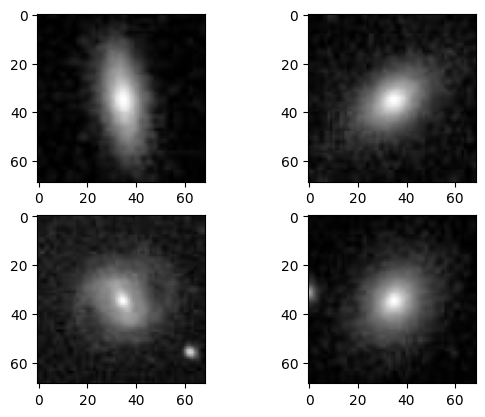

In [39]:
random.shuffle(photos_train)
for i,tupla in enumerate(photos_train[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(tupla[1], cmap='gray')

In [40]:
df_train = pd.DataFrame(photos_train, columns=['name','photo'])
df_train['test'] = 0
display(df_train)

,name,photo,test
0,184768,"[[3, 2, 1, 3, 7, 10, 12, 13, 4, 2, 1, 1, 4, 6,...",0
1,217095,"[[5, 5, 3, 1, 1, 3, 10, 16, 33, 30, 28, 23, 11...",0
2,131076,"[[23, 18, 17, 20, 18, 13, 14, 20, 14, 19, 23, ...",0
3,167911,"[[0, 2, 5, 3, 0, 0, 1, 4, 5, 4, 2, 1, 0, 1, 2,...",0
4,47202,"[[4, 3, 2, 1, 2, 3, 4, 5, 3, 2, 2, 4, 6, 6, 5,...",0
...,...,...,...
63791,107319,"[[2, 8, 14, 14, 8, 3, 3, 5, 6, 5, 5, 5, 6, 6, ...",0
63792,109055,"[[7, 7, 8, 8, 7, 5, 4, 3, 2, 7, 12, 11, 6, 2, ...",0
63793,73487,"[[0, 3, 7, 7, 4, 1, 1, 2, 3, 4, 5, 6, 6, 6, 5,...",0
63794,87221,"[[1, 1, 3, 6, 9, 9, 6, 4, 11, 2, 2, 11, 12, 3,...",0


In [41]:
df_test = pd.DataFrame(photos_test, columns=['name','photo'])
df_test['test'] = 1
display(df_test)

,name,photo,test
0,195723,"[[8, 8, 7, 6, 6, 5, 4, 4, 0, 5, 10, 9, 5, 2, 4...",1
1,214658,"[[55, 56, 59, 60, 59, 57, 54, 51, 50, 50, 49, ...",1
2,156896,"[[4, 5, 6, 6, 5, 4, 2, 1, 0, 5, 9, 9, 4, 1, 1,...",1
3,178940,"[[1, 4, 10, 12, 11, 8, 6, 5, 16, 15, 12, 7, 4,...",1
4,46240,"[[5, 9, 13, 13, 11, 9, 10, 12, 14, 12, 11, 11,...",1
...,...,...,...
7016,101897,"[[5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 6, 6,...",1
7017,30612,"[[4, 10, 10, 4, 1, 4, 4, 1, 3, 1, 1, 1, 3, 5, ...",1
7018,38510,"[[6, 5, 5, 4, 4, 5, 5, 6, 3, 4, 5, 6, 6, 6, 6,...",1
7019,179292,"[[5, 4, 3, 2, 1, 0, 0, 0, 0, 1, 3, 6, 8, 8, 8,...",1


In [42]:
df_concat = pd.concat([df_train, df_test], ignore_index=True)
df_concat['name'] = df_concat['name'].astype(int)
df = df.merge(df_concat, left_on='asset_id', right_on='name',how='inner')
display(df)

,Unnamed: 0,dr7objid,asset_id,gz2class,total_classifications,total_votes,agreement,name,photo,test
0,86689,587739845921276020,145504,Ei,36,124,0.445180,145504,"[[1, 3, 3, 3, 2, 2, 4, 7, 5, 2, 0, 2, 8, 9, 6,...",0
1,54415,587731891651477629,49282,Er,44,143,0.502510,49282,"[[8, 7, 6, 6, 5, 4, 3, 3, 6, 5, 3, 2, 1, 1, 2,...",1
2,95986,587732701790011680,59563,Er,42,132,0.665350,59563,"[[9, 13, 18, 17, 12, 8, 10, 12, 13, 9, 6, 8, 1...",0
3,18693,587735662618738871,83947,Er,40,130,0.580474,83947,"[[6, 6, 6, 5, 5, 4, 4, 4, 4, 1, 1, 4, 4, 2, 6,...",0
4,31410,587728881411031151,26336,Ei(o),57,211,0.559726,26336,"[[10, 9, 8, 9, 10, 10, 9, 8, 4, 6, 9, 11, 8, 4...",0
...,...,...,...,...,...,...,...,...,...,...
70812,205055,587742061070057610,264708,SBd2l,29,191,0.560201,264708,"[[0, 0, 0, 1, 1, 1, 2, 2, 5, 4, 3, 2, 1, 1, 1,...",0
70813,205116,588017990687260812,229933,SBb2l,28,161,0.456436,229933,"[[2, 5, 8, 9, 7, 5, 2, 1, 0, 2, 5, 5, 3, 2, 3,...",0
70814,205599,587742864749560106,266731,SBd2m(i),35,230,0.380240,266731,"[[4, 1, 0, 1, 3, 4, 2, 0, 13, 8, 3, 2, 4, 7, 7...",0
70815,205866,588017979414347813,271907,SBd2l,32,235,0.619323,271907,"[[4, 3, 2, 4, 7, 7, 4, 0, 4, 3, 3, 4, 7, 9, 9,...",0


In [43]:
X_train = []
y_train = []

X_test = []
y_test = []

for index, row in df.iterrows():
    if row['test'] == 0:
        X_train.append(row['photo'])
        y_train.append(row['gz2class'])
    else:
        X_test.append(row['photo'])
        y_test.append(row['gz2class'])

In [44]:
print(len(X_train))
print(X_train)

63796


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [45]:
print(len(y_train))
print(y_train)

63796
['Ei', 'Er', 'Er', 'Ei(o)', 'Er', 'Ec', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Er(o)', 'Ec', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Ec', 'Er', 'Ei', 'Ei', 'Ec', 'Ec', 'Er', 'Er', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Ec', 'Er', 'Er(m)', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Er(m)', 'Er', 'Er', 'Er', 'Er', 'Er', 'Ei', 'Ei(i)', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Er', 'Ei', 'Ei', 'Er', 'Er', 'Er', 'Er', 'Er', 'Er', 'Ei', 'Er', 'Er', 'Ei', 'Er', 'Er', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Ei(u)', 'Ei', 'Er', 'Er', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Ec', 'Ei', 'Er', 'Er', 'Er(m)', 'Ei', 'Er', 'Er', 'Ec', 'Er(m)', 'Ec', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Er', 'Ei', 'Er', 'Ec', 'Er', 'Ei', 'Er', 'Ec', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Ec', 'Ei', 'Er', 'Er', 'Ei

In [46]:
print(len(X_test))
print(X_test)

7021
[array([[8, 7, 6, ..., 6, 6, 4],
       [7, 7, 6, ..., 5, 5, 4],
       [6, 6, 6, ..., 4, 4, 3],
       ...,
       [3, 3, 4, ..., 7, 8, 9],
       [4, 4, 4, ..., 7, 8, 9],
       [5, 4, 4, ..., 5, 7, 8]], dtype=uint8), array([[5, 2, 2, ..., 2, 2, 2],
       [4, 2, 2, ..., 3, 3, 3],
       [2, 2, 3, ..., 4, 4, 4],
       ...,
       [1, 3, 5, ..., 4, 3, 0],
       [1, 3, 5, ..., 4, 3, 1],
       [0, 1, 3, ..., 5, 3, 1]], dtype=uint8), array([[3, 2, 1, ..., 6, 6, 2],
       [2, 2, 2, ..., 7, 6, 4],
       [0, 1, 3, ..., 8, 7, 6],
       ...,
       [9, 8, 7, ..., 6, 5, 3],
       [7, 6, 6, ..., 8, 7, 5],
       [3, 3, 4, ..., 9, 8, 6]], dtype=uint8), array([[16, 13,  8, ...,  6,  7,  2],
       [19, 17, 13, ...,  3,  7,  1],
       [17, 16, 14, ...,  7, 14, 10],
       ...,
       [ 6,  5,  7, ...,  8, 11, 15],
       [ 5,  5,  6, ...,  7,  6,  7],
       [ 4,  6,  5, ...,  5,  5,  6]], dtype=uint8), array([[ 7,  4,  3, ...,  9,  8,  7],
       [12,  8,  5, ...,  6,  4,  3],
      

In [47]:
print(len(y_test))
print(y_test)

7021
['Er', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Ei(m)', 'Er', 'Ei', 'Ei', 'Ec', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Er', 'Er', 'Ei(r)', 'Ec', 'Ei', 'Er', 'Ei', 'Ei', 'Er', 'Ei', 'Ec', 'Ei', 'Ei', 'Ei', 'Er', 'Ei', 'Ei', 'Er', 'Er', 'Ei(o)', 'Ei(m)', 'Ei', 'Ei', 'Ec', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Ei(u)', 'Ei', 'Er', 'Ei', 'Ei', 'Ei', 'Ei', 'Ei', 'Er', 'Ec', 'Er', 'Ei', 'Ei', 'Ei', 'Er', 'Er(m)', 'Er', 'Er', 'Ei', 'Er', 'Er', 'Er', 'Ec', 'Ei', 'Ei', 'Er', 'Ei(o)', 'Ei', 'Ei', 'Ei', 'Er', 'Er', 'Er', 'Ec', 'Er', 'Ei', 'Ec', 'Er', 'Ei', 'Er', 'Er', 'Er', 'Ei', 'Ei', 'Ei', 'Ec', 'Ei', 'Ei', 'Ei', 'Er(l)', 'Ei', 'Ec', 'Ec', 'Ei', 'Ei', 'Er', 'Ei', 'Ei', 'Er(o)', 'Ec(i)', 'Ei', 'Ei', 'Ei', 'Er', 'Ec', 'Er', 'Ei', 'Er', 'Ei', 'Ei', 'Er', 'Ei', 'Er', 'Ei', 'Er', 'Er', 'Ec', 'Er', 'Ec', 'Er(o)', 'Ei', 'Er', 'Er', 'Ei', 'Ei', 'Er', 'Ei', 'Er', '

In [48]:
X_train = np.array(X_train).astype(float) / 255
X_test = np.array(X_test).astype(float) / 255
print(X_train)

[[[0.00392157 0.01176471 0.01176471 ... 0.01960784 0.01568627 0.01176471]
  [0.         0.00392157 0.00784314 ... 0.01176471 0.00784314 0.00392157]
  [0.00392157 0.00784314 0.01176471 ... 0.01568627 0.01176471 0.00784314]
  ...
  [0.00392157 0.01176471 0.01568627 ... 0.00784314 0.00784314 0.00784314]
  [0.00392157 0.00784314 0.01568627 ... 0.00784314 0.00784314 0.01176471]
  [0.00392157 0.00784314 0.01176471 ... 0.00784314 0.01176471 0.01568627]]

 [[0.03529412 0.05098039 0.07058824 ... 0.01568627 0.01568627 0.01568627]
  [0.03921569 0.05882353 0.07843137 ... 0.01176471 0.01176471 0.01176471]
  [0.04705882 0.06666667 0.08235294 ... 0.00392157 0.00392157 0.00392157]
  ...
  [0.02745098 0.02745098 0.02745098 ... 0.02745098 0.02745098 0.03137255]
  [0.02352941 0.02352941 0.02745098 ... 0.01960784 0.01960784 0.01960784]
  [0.01960784 0.02745098 0.03529412 ... 0.01568627 0.01176471 0.01176471]]

 [[0.02352941 0.02352941 0.02352941 ... 0.00784314 0.00392157 0.00392157]
  [0.02352941 0.023529

In [49]:
def convert_element(element):
    if element.startswith('SB'):
        return 2
    elif element.startswith('S'):
        return 1
    else:
        return 0

In [50]:
y_train = [convert_element(element) for element in y_train]
y_test = [convert_element(element) for element in y_test]
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_train)
print(y_test)

[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]


In [51]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [52]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

63796
63796
7021
7021


In [53]:
print(y_train)
print(y_test)

[0 2 2 ... 0 2 0]
[1 0 0 ... 1 2 1]


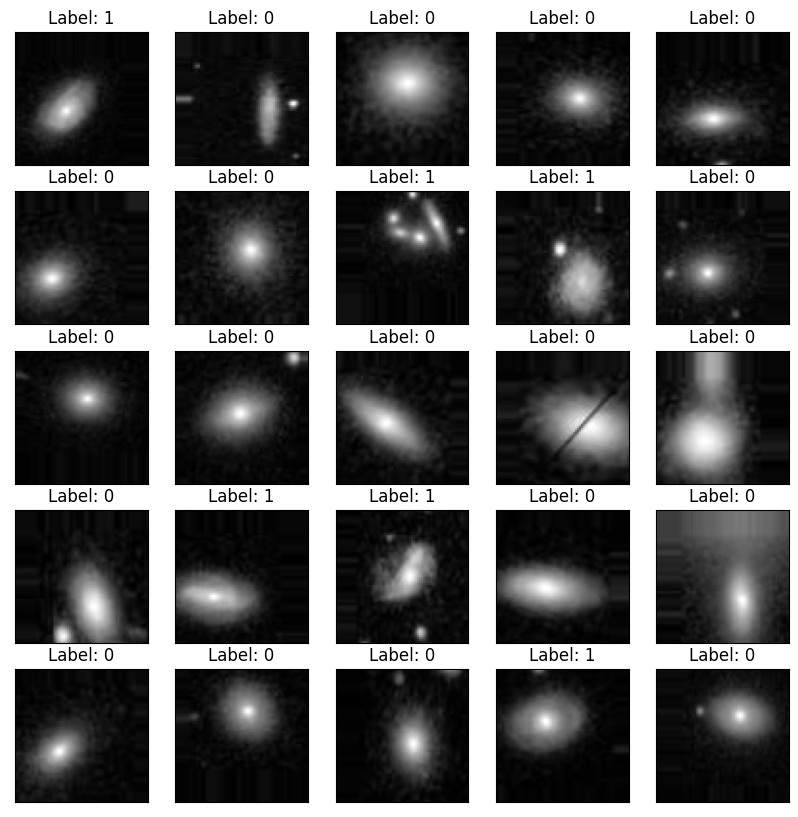

'\n    Label 0 --> E\n    Label 1 --> S\n    Label 2 --> SB\n'

In [54]:
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True
)

X_train = np.expand_dims(X_train, axis=-1)

iterator = datagen.flow(X_train, y_train, batch_size=25)

X_batch, y_batch = iterator.next()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_batch[i].reshape(int(resolution),int(resolution)), cmap='gray')
    plt.title('Label: {}'.format(y_batch[i]))
plt.show()

"""
    Label 0 --> E
    Label 1 --> S
    Label 2 --> SB
"""

In [55]:
EPOCHS = 200
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.001
KFOLD_NSPLITS = 5

BEST_MODEL_PATH = 'best_model_min_agreement_'+str(int(MIN_AGREEMENT*100))+'.h5'

kf = KFold(n_splits=KFOLD_NSPLITS, shuffle=True)

results = []
results_E = []
results_S = []
results_SB = []

for train_index, test_index in kf.split(X_train):    
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(int(resolution), int(resolution), 1)),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

    model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.00001, verbose=1)
    checkpoint = ModelCheckpoint(BEST_MODEL_PATH, monitor='val_sparse_categorical_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
    
    model.fit(datagen.flow(X_train_kf, y_train_kf, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_kf,y_test_kf),
        callbacks=[checkpoint]
    )
    
    scores = model.evaluate(X_test_kf, y_test_kf)
    print("Accuracy: %.2f%%" % (scores[1] * 100))
    
    indexs = (y_test_kf == 0)
    y_test_kf_E = y_test_kf[indexs]
    X_test_kf_E = X_test_kf[indexs]
    scores_E = model.evaluate(X_test_kf_E, y_test_kf_E)
    print("Accuracy E: %.2f%%" % (scores_E[1] * 100))
    
    indexs = (y_test_kf == 1)
    y_test_kf_S = y_test_kf[indexs]
    X_test_kf_S = X_test_kf[indexs]
    scores_S = model.evaluate(X_test_kf_S, y_test_kf_S)
    print("Accuracy S: %.2f%%" % (scores_S[1] * 100))
    
    indexs = (y_test_kf == 2)
    y_test_kf_SB = y_test_kf[indexs]
    X_test_kf_SB = X_test_kf[indexs]
    scores_SB = model.evaluate(X_test_kf_SB, y_test_kf_SB)
    print("Accuracy SB: %.2f%%" % (scores_SB[1] * 100))

    results.append(scores[1] * 100)
    results_E.append(scores_E[1] * 100)
    results_S.append(scores_S[1] * 100)
    results_SB.append(scores_SB[1] * 100)

mean = np.mean(results)
std = np.std(results)
mean_E = np.mean(results_E)
std_E = np.std(results_E)
mean_S = np.mean(results_S)
std_S = np.std(results_S)
mean_SB = np.mean(results_SB)
std_SB = np.std(results_SB)

print('\n')
print("-----------------------------")
print(f"Mean precision: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print("-----------------------------")
print(f"Mean precision for E class: {mean_E:.2f}")
print(f"Standard deviation for E class: {std_E:.2f}")
print("-----------------------------")
print(f"Mean precision for S class: {mean_S:.2f}")
print(f"Standard deviation for S class: {std_S:.2f}")
print("-----------------------------")
print(f"Mean precision for SB class: {mean_SB:.2f}")
print(f"Standard deviation for SB class: {std_SB:.2f}")

Epoch 1/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.8772 - sparse_categorical_accuracy: 0.6090
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.62908, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.8769 - sparse_categorical_accuracy: 0.6092 - val_loss: 0.8418 - val_sparse_categorical_accuracy: 0.6291
Epoch 2/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.8079 - sparse_categorical_accuracy: 0.6514
Epoch 2: val_sparse_categorical_accuracy improved from 0.62908 to 0.69702, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 11ms/step - loss: 0.8080 - sparse_categorical_accuracy: 0.6514 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.6970
Epoch 3/200
1595/1595 [==============================] - ETA: 0s - loss: 0.7156 - sparse_categorical_accuracy: 0.6927
Epoch 3: val_sparse_categorical_accuracy improved from 0.6970

Epoch 22/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5551 - sparse_categorical_accuracy: 0.7815
Epoch 22: val_sparse_categorical_accuracy improved from 0.78495 to 0.78950, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5551 - sparse_categorical_accuracy: 0.7815 - val_loss: 0.5398 - val_sparse_categorical_accuracy: 0.7895
Epoch 23/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5528 - sparse_categorical_accuracy: 0.7813
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.78950
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.5563 - val_sparse_categorical_accuracy: 0.7784
Epoch 24/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5516 - sparse_categorical_accuracy: 0.7825
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.78950
1595/1595 [======================

Epoch 44/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5313 - sparse_categorical_accuracy: 0.7923
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.79859
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5314 - sparse_categorical_accuracy: 0.7923 - val_loss: 0.5250 - val_sparse_categorical_accuracy: 0.7957
Epoch 45/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5306 - sparse_categorical_accuracy: 0.7920
Epoch 45: val_sparse_categorical_accuracy did not improve from 0.79859
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.7920 - val_loss: 0.5438 - val_sparse_categorical_accuracy: 0.7857
Epoch 46/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5292 - sparse_categorical_accuracy: 0.7919
Epoch 46: val_sparse_categorical_accuracy did not improve from 0.79859
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5293 - sparse_c

1591/1595 [============================>.] - ETA: 0s - loss: 0.5195 - sparse_categorical_accuracy: 0.7943
Epoch 66: val_sparse_categorical_accuracy did not improve from 0.80047
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.5125 - val_sparse_categorical_accuracy: 0.7989
Epoch 67/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5186 - sparse_categorical_accuracy: 0.7960
Epoch 67: val_sparse_categorical_accuracy did not improve from 0.80047
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5187 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.5214 - val_sparse_categorical_accuracy: 0.7913
Epoch 68/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5208 - sparse_categorical_accuracy: 0.7938
Epoch 68: val_sparse_categorical_accuracy did not improve from 0.80047
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5208 - sparse_categorical_ac

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.5190 - val_sparse_categorical_accuracy: 0.7971
Epoch 89/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5148 - sparse_categorical_accuracy: 0.7959
Epoch 89: val_sparse_categorical_accuracy did not improve from 0.80259
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5148 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.5090 - val_sparse_categorical_accuracy: 0.7988
Epoch 90/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5165 - sparse_categorical_accuracy: 0.7951
Epoch 90: val_sparse_categorical_accuracy did not improve from 0.80259
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5165 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.5225 - val_sparse_categorical_accuracy: 0.7942
Epoch 91/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5144 - sparse_categorical

1593/1595 [============================>.] - ETA: 0s - loss: 0.5123 - sparse_categorical_accuracy: 0.7961
Epoch 111: val_sparse_categorical_accuracy improved from 0.80259 to 0.80392, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5124 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.5143 - val_sparse_categorical_accuracy: 0.8039
Epoch 112/200
1589/1595 [============================>.] - ETA: 0s - loss: 0.5118 - sparse_categorical_accuracy: 0.7981
Epoch 112: val_sparse_categorical_accuracy did not improve from 0.80392
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5117 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.5106 - val_sparse_categorical_accuracy: 0.8033
Epoch 113/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5117 - sparse_categorical_accuracy: 0.7982
Epoch 113: val_sparse_categorical_accuracy did not improve from 0.80392
1595/1595 [==============================

1591/1595 [============================>.] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.7983
Epoch 133: val_sparse_categorical_accuracy did not improve from 0.80423
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5100 - sparse_categorical_accuracy: 0.7982 - val_loss: 0.5058 - val_sparse_categorical_accuracy: 0.8004
Epoch 134/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5095 - sparse_categorical_accuracy: 0.7992
Epoch 134: val_sparse_categorical_accuracy did not improve from 0.80423
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.7992 - val_loss: 0.5224 - val_sparse_categorical_accuracy: 0.7994
Epoch 135/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5119 - sparse_categorical_accuracy: 0.7987
Epoch 135: val_sparse_categorical_accuracy did not improve from 0.80423
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5118 - sparse_categoric

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5081 - sparse_categorical_accuracy: 0.8017 - val_loss: 0.5162 - val_sparse_categorical_accuracy: 0.7961
Epoch 156/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5068 - sparse_categorical_accuracy: 0.7996
Epoch 156: val_sparse_categorical_accuracy did not improve from 0.80745
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5067 - sparse_categorical_accuracy: 0.7996 - val_loss: 0.5216 - val_sparse_categorical_accuracy: 0.7986
Epoch 157/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5071 - sparse_categorical_accuracy: 0.8011
Epoch 157: val_sparse_categorical_accuracy did not improve from 0.80745
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5072 - sparse_categorical_accuracy: 0.8011 - val_loss: 0.5321 - val_sparse_categorical_accuracy: 0.7909
Epoch 158/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5070 - sparse_catego

Epoch 178/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5069 - sparse_categorical_accuracy: 0.8007
Epoch 178: val_sparse_categorical_accuracy did not improve from 0.80807
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5069 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.5152 - val_sparse_categorical_accuracy: 0.7962
Epoch 179/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.8006
Epoch 179: val_sparse_categorical_accuracy did not improve from 0.80807
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.5043 - val_sparse_categorical_accuracy: 0.8038
Epoch 180/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5056 - sparse_categorical_accuracy: 0.8006
Epoch 180: val_sparse_categorical_accuracy did not improve from 0.80807
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5055 - sp

399/399 [==============================] - 1s 2ms/step - loss: 0.5283 - sparse_categorical_accuracy: 0.7978
Accuracy: 79.78%
219/219 [==============================] - 1s 2ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9562
Accuracy E: 95.62%
124/124 [==============================] - 0s 2ms/step - loss: 0.7844 - sparse_categorical_accuracy: 0.6282
Accuracy S: 62.82%
57/57 [==============================] - 0s 3ms/step - loss: 0.8933 - sparse_categorical_accuracy: 0.5537
Accuracy SB: 55.37%
Epoch 1/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.8825 - sparse_categorical_accuracy: 0.6048
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.64096, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.8823 - sparse_categorical_accuracy: 0.6049 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.6410
Epoch 2/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.8321 - spar

Epoch 20/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5545 - sparse_categorical_accuracy: 0.7824
Epoch 20: val_sparse_categorical_accuracy did not improve from 0.78321
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5544 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.5795 - val_sparse_categorical_accuracy: 0.7659
Epoch 21/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5556 - sparse_categorical_accuracy: 0.7804
Epoch 21: val_sparse_categorical_accuracy did not improve from 0.78321
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7804 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.7824
Epoch 22/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5504 - sparse_categorical_accuracy: 0.7830
Epoch 22: val_sparse_categorical_accuracy did not improve from 0.78321
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5504 - sparse_c

Epoch 42/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5324 - sparse_categorical_accuracy: 0.7898
Epoch 42: val_sparse_categorical_accuracy did not improve from 0.79074
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5324 - sparse_categorical_accuracy: 0.7899 - val_loss: 0.5352 - val_sparse_categorical_accuracy: 0.7874
Epoch 43/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5323 - sparse_categorical_accuracy: 0.7910
Epoch 43: val_sparse_categorical_accuracy did not improve from 0.79074
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.5268 - val_sparse_categorical_accuracy: 0.7885
Epoch 44/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5308 - sparse_categorical_accuracy: 0.7907
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.79074
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5308 - sparse_c

1594/1595 [============================>.] - ETA: 0s - loss: 0.5228 - sparse_categorical_accuracy: 0.7952
Epoch 64: val_sparse_categorical_accuracy did not improve from 0.79560
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5227 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.5303 - val_sparse_categorical_accuracy: 0.7899
Epoch 65/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5215 - sparse_categorical_accuracy: 0.7943
Epoch 65: val_sparse_categorical_accuracy did not improve from 0.79560
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5215 - sparse_categorical_accuracy: 0.7943 - val_loss: 0.5412 - val_sparse_categorical_accuracy: 0.7860
Epoch 66/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5210 - sparse_categorical_accuracy: 0.7952
Epoch 66: val_sparse_categorical_accuracy did not improve from 0.79560
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5210 - sparse_categorical_ac

Epoch 86/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5180 - sparse_categorical_accuracy: 0.7955
Epoch 86: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.7953 - val_loss: 0.5212 - val_sparse_categorical_accuracy: 0.7919
Epoch 87/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5157 - sparse_categorical_accuracy: 0.7978
Epoch 87: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5157 - sparse_categorical_accuracy: 0.7978 - val_loss: 0.5174 - val_sparse_categorical_accuracy: 0.7947
Epoch 88/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5183 - sparse_categorical_accuracy: 0.7964
Epoch 88: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5183 - sparse_c

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5132 - sparse_categorical_accuracy: 0.7982 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.7975
Epoch 109/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5136 - sparse_categorical_accuracy: 0.7980
Epoch 109: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5135 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.5249 - val_sparse_categorical_accuracy: 0.7958
Epoch 110/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5153 - sparse_categorical_accuracy: 0.7971
Epoch 110: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5153 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.5133 - val_sparse_categorical_accuracy: 0.7963
Epoch 111/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5113 - sparse_catego

Epoch 131/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5108 - sparse_categorical_accuracy: 0.7991
Epoch 131: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5108 - sparse_categorical_accuracy: 0.7991 - val_loss: 0.5111 - val_sparse_categorical_accuracy: 0.7991
Epoch 132/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5101 - sparse_categorical_accuracy: 0.7994
Epoch 132: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5102 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.5130 - val_sparse_categorical_accuracy: 0.7966
Epoch 133/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5104 - sparse_categorical_accuracy: 0.7998
Epoch 133: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5104 - sp

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.5460 - val_sparse_categorical_accuracy: 0.7912
Epoch 154/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.7998
Epoch 154: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.7998 - val_loss: 0.5164 - val_sparse_categorical_accuracy: 0.7907
Epoch 155/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5070 - sparse_categorical_accuracy: 0.8000
Epoch 155: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5070 - sparse_categorical_accuracy: 0.8000 - val_loss: 0.5122 - val_sparse_categorical_accuracy: 0.7936
Epoch 156/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5076 - sparse_catego

Epoch 176/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5074 - sparse_categorical_accuracy: 0.8013
Epoch 176: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5074 - sparse_categorical_accuracy: 0.8012 - val_loss: 0.5032 - val_sparse_categorical_accuracy: 0.7965
Epoch 177/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5061 - sparse_categorical_accuracy: 0.8009
Epoch 177: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5061 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.5324 - val_sparse_categorical_accuracy: 0.7894
Epoch 178/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5072 - sparse_categorical_accuracy: 0.7993
Epoch 178: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5073 - sp

1595/1595 [==============================] - 17s 10ms/step - loss: 0.5029 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.5123 - val_sparse_categorical_accuracy: 0.7979
Epoch 199/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5062 - sparse_categorical_accuracy: 0.8007
Epoch 199: val_sparse_categorical_accuracy did not improve from 0.80085
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5061 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.5117 - val_sparse_categorical_accuracy: 0.7954
Epoch 200/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5074 - sparse_categorical_accuracy: 0.8005
Epoch 200: val_sparse_categorical_accuracy did not improve from 0.80085
399/399 [==============================] - 1s 2ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.7946
Accuracy: 79.46%
223/223 [==============================] - 1s 2ms/step - loss: 0.3396 - sparse_categorical_accuracy: 0.9142
Accuracy E: 91.42%
120/120 [=========

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5595 - sparse_categorical_accuracy: 0.7797 - val_loss: 0.5487 - val_sparse_categorical_accuracy: 0.7833
Epoch 19/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5552 - sparse_categorical_accuracy: 0.7812
Epoch 19: val_sparse_categorical_accuracy improved from 0.78329 to 0.78517, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5553 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.5440 - val_sparse_categorical_accuracy: 0.7852
Epoch 20/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5514 - sparse_categorical_accuracy: 0.7828
Epoch 20: val_sparse_categorical_accuracy did not improve from 0.78517
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5516 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.5482 - val_sparse_categorical_accuracy: 0.7823
Epoch 21/200
1595/1595 [==========================

1594/1595 [============================>.] - ETA: 0s - loss: 0.5306 - sparse_categorical_accuracy: 0.7920
Epoch 40: val_sparse_categorical_accuracy did not improve from 0.79340
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5306 - sparse_categorical_accuracy: 0.7920 - val_loss: 0.5286 - val_sparse_categorical_accuracy: 0.7904
Epoch 41/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5286 - sparse_categorical_accuracy: 0.7926
Epoch 41: val_sparse_categorical_accuracy did not improve from 0.79340
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.7927 - val_loss: 0.5367 - val_sparse_categorical_accuracy: 0.7897
Epoch 42/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5305 - sparse_categorical_accuracy: 0.7915
Epoch 42: val_sparse_categorical_accuracy did not improve from 0.79340
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5305 - sparse_categorical_ac

1594/1595 [============================>.] - ETA: 0s - loss: 0.5184 - sparse_categorical_accuracy: 0.7959
Epoch 62: val_sparse_categorical_accuracy did not improve from 0.79865
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5184 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.5074 - val_sparse_categorical_accuracy: 0.7979
Epoch 63/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5193 - sparse_categorical_accuracy: 0.7969
Epoch 63: val_sparse_categorical_accuracy did not improve from 0.79865
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5193 - sparse_categorical_accuracy: 0.7970 - val_loss: 0.5266 - val_sparse_categorical_accuracy: 0.7900
Epoch 64/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5181 - sparse_categorical_accuracy: 0.7959
Epoch 64: val_sparse_categorical_accuracy did not improve from 0.79865
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5182 - sparse_categorical_ac

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5164 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.5184 - val_sparse_categorical_accuracy: 0.7970
Epoch 85/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5135 - sparse_categorical_accuracy: 0.7984
Epoch 85: val_sparse_categorical_accuracy did not improve from 0.80061
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5134 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.7932
Epoch 86/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5155 - sparse_categorical_accuracy: 0.7975
Epoch 86: val_sparse_categorical_accuracy did not improve from 0.80061
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5155 - sparse_categorical_accuracy: 0.7975 - val_loss: 0.5137 - val_sparse_categorical_accuracy: 0.7964
Epoch 87/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5144 - sparse_categorical

Epoch 107/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5099 - sparse_categorical_accuracy: 0.7984
Epoch 107: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5100 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.5181 - val_sparse_categorical_accuracy: 0.7926
Epoch 108/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5097 - sparse_categorical_accuracy: 0.8001
Epoch 108: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.5104 - val_sparse_categorical_accuracy: 0.7983
Epoch 109/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5100 - sparse_categorical_accuracy: 0.7999
Epoch 109: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5099 - sp

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5090 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.5338 - val_sparse_categorical_accuracy: 0.7942
Epoch 130/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5061 - sparse_categorical_accuracy: 0.8008
Epoch 130: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5062 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.5121 - val_sparse_categorical_accuracy: 0.7966
Epoch 131/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5079 - sparse_categorical_accuracy: 0.7999
Epoch 131: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5080 - sparse_categorical_accuracy: 0.7999 - val_loss: 0.5071 - val_sparse_categorical_accuracy: 0.8014
Epoch 132/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5062 - sparse_catego

Epoch 152/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5055 - sparse_categorical_accuracy: 0.8008
Epoch 152: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5055 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.8013
Epoch 153/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5042 - sparse_categorical_accuracy: 0.8022
Epoch 153: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.8022 - val_loss: 0.5190 - val_sparse_categorical_accuracy: 0.7958
Epoch 154/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5048 - sparse_categorical_accuracy: 0.8024
Epoch 154: val_sparse_categorical_accuracy did not improve from 0.80273
1595/1595 [==============================] - 17s 10ms/step - loss: 0.5050 - sp

1594/1595 [============================>.] - ETA: 0s - loss: 0.5038 - sparse_categorical_accuracy: 0.8010
Epoch 174: val_sparse_categorical_accuracy did not improve from 0.80469
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.8010 - val_loss: 0.5135 - val_sparse_categorical_accuracy: 0.7984
Epoch 175/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5036 - sparse_categorical_accuracy: 0.8015
Epoch 175: val_sparse_categorical_accuracy did not improve from 0.80469
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5035 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.5278 - val_sparse_categorical_accuracy: 0.7920
Epoch 176/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5029 - sparse_categorical_accuracy: 0.8014
Epoch 176: val_sparse_categorical_accuracy did not improve from 0.80469
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5028 - sparse_categoric

1595/1595 [==============================] - 17s 10ms/step - loss: 0.5035 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.5074 - val_sparse_categorical_accuracy: 0.8019
Epoch 197/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5030 - sparse_categorical_accuracy: 0.8018
Epoch 197: val_sparse_categorical_accuracy did not improve from 0.80469
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5030 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.5082 - val_sparse_categorical_accuracy: 0.8000
Epoch 198/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5046 - sparse_categorical_accuracy: 0.8022
Epoch 198: val_sparse_categorical_accuracy did not improve from 0.80469
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5046 - sparse_categorical_accuracy: 0.8022 - val_loss: 0.5237 - val_sparse_categorical_accuracy: 0.7938
Epoch 199/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5026 - sparse_catego

1590/1595 [============================>.] - ETA: 0s - loss: 0.5970 - sparse_categorical_accuracy: 0.7594
Epoch 16: val_sparse_categorical_accuracy improved from 0.77169 to 0.77467, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.5743 - val_sparse_categorical_accuracy: 0.7747
Epoch 17/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5934 - sparse_categorical_accuracy: 0.7635
Epoch 17: val_sparse_categorical_accuracy improved from 0.77467 to 0.77780, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.5640 - val_sparse_categorical_accuracy: 0.7778
Epoch 18/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5879 - sparse_categorical_accuracy: 0.7654
Epoch 18: val_sparse_categorical_accuracy improved from 0.77780 to

1595/1595 [==============================] - ETA: 0s - loss: 0.5513 - sparse_categorical_accuracy: 0.7819
Epoch 37: val_sparse_categorical_accuracy did not improve from 0.79450
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5513 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.5273 - val_sparse_categorical_accuracy: 0.7914
Epoch 38/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5505 - sparse_categorical_accuracy: 0.7827
Epoch 38: val_sparse_categorical_accuracy improved from 0.79450 to 0.79607, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5504 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.5204 - val_sparse_categorical_accuracy: 0.7961
Epoch 39/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5496 - sparse_categorical_accuracy: 0.7829
Epoch 39: val_sparse_categorical_accuracy did not improve from 0.79607
1595/1595 [==============================] - 1

1593/1595 [============================>.] - ETA: 0s - loss: 0.5359 - sparse_categorical_accuracy: 0.7893
Epoch 59: val_sparse_categorical_accuracy improved from 0.79904 to 0.80116, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5359 - sparse_categorical_accuracy: 0.7893 - val_loss: 0.5131 - val_sparse_categorical_accuracy: 0.8012
Epoch 60/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5372 - sparse_categorical_accuracy: 0.7879
Epoch 60: val_sparse_categorical_accuracy did not improve from 0.80116
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5374 - sparse_categorical_accuracy: 0.7879 - val_loss: 0.5086 - val_sparse_categorical_accuracy: 0.8009
Epoch 61/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5342 - sparse_categorical_accuracy: 0.7891
Epoch 61: val_sparse_categorical_accuracy did not improve from 0.80116
1595/1595 [==============================] - 1

1594/1595 [============================>.] - ETA: 0s - loss: 0.5281 - sparse_categorical_accuracy: 0.7918
Epoch 81: val_sparse_categorical_accuracy did not improve from 0.80288
1595/1595 [==============================] - 19s 12ms/step - loss: 0.5281 - sparse_categorical_accuracy: 0.7918 - val_loss: 0.5037 - val_sparse_categorical_accuracy: 0.8023
Epoch 82/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5255 - sparse_categorical_accuracy: 0.7941
Epoch 82: val_sparse_categorical_accuracy did not improve from 0.80288
1595/1595 [==============================] - 19s 12ms/step - loss: 0.5255 - sparse_categorical_accuracy: 0.7941 - val_loss: 0.5148 - val_sparse_categorical_accuracy: 0.7991
Epoch 83/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5269 - sparse_categorical_accuracy: 0.7929
Epoch 83: val_sparse_categorical_accuracy did not improve from 0.80288
1595/1595 [==============================] - 20s 12ms/step - loss: 0.5269 - sparse_categorical_ac

1594/1595 [============================>.] - ETA: 0s - loss: 0.5245 - sparse_categorical_accuracy: 0.7933
Epoch 103: val_sparse_categorical_accuracy did not improve from 0.80578
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5246 - sparse_categorical_accuracy: 0.7933 - val_loss: 0.5037 - val_sparse_categorical_accuracy: 0.8050
Epoch 104/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5247 - sparse_categorical_accuracy: 0.7932
Epoch 104: val_sparse_categorical_accuracy did not improve from 0.80578
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5246 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.5027 - val_sparse_categorical_accuracy: 0.8041
Epoch 105/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5216 - sparse_categorical_accuracy: 0.7943
Epoch 105: val_sparse_categorical_accuracy did not improve from 0.80578
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5214 - sparse_categoric

1595/1595 [==============================] - 19s 12ms/step - loss: 0.5180 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.5071 - val_sparse_categorical_accuracy: 0.8053
Epoch 126/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5197 - sparse_categorical_accuracy: 0.7958
Epoch 126: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 19s 12ms/step - loss: 0.5198 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.5008 - val_sparse_categorical_accuracy: 0.8026
Epoch 127/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5193 - sparse_categorical_accuracy: 0.7968
Epoch 127: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5193 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.5041 - val_sparse_categorical_accuracy: 0.8008
Epoch 128/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5178 - sparse_catego

Epoch 148/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5158 - sparse_categorical_accuracy: 0.7975
Epoch 148: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5158 - sparse_categorical_accuracy: 0.7975 - val_loss: 0.5119 - val_sparse_categorical_accuracy: 0.7982
Epoch 149/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5150 - sparse_categorical_accuracy: 0.7976
Epoch 149: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5149 - sparse_categorical_accuracy: 0.7977 - val_loss: 0.5091 - val_sparse_categorical_accuracy: 0.7993
Epoch 150/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5174 - sparse_categorical_accuracy: 0.7964
Epoch 150: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5174 - sp

1595/1595 [==============================] - 18s 11ms/step - loss: 0.5137 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.4983 - val_sparse_categorical_accuracy: 0.8052
Epoch 171/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5121 - sparse_categorical_accuracy: 0.7993
Epoch 171: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5119 - sparse_categorical_accuracy: 0.7994 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.8019
Epoch 172/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5136 - sparse_categorical_accuracy: 0.7984
Epoch 172: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 12ms/step - loss: 0.5134 - sparse_categorical_accuracy: 0.7985 - val_loss: 0.5044 - val_sparse_categorical_accuracy: 0.8048
Epoch 173/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5135 - sparse_catego

Epoch 193/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5127 - sparse_categorical_accuracy: 0.7983
Epoch 193: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5126 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.8025
Epoch 194/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5099 - sparse_categorical_accuracy: 0.7995
Epoch 194: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5100 - sparse_categorical_accuracy: 0.7995 - val_loss: 0.5041 - val_sparse_categorical_accuracy: 0.7999
Epoch 195/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5145 - sparse_categorical_accuracy: 0.7965
Epoch 195: val_sparse_categorical_accuracy did not improve from 0.80767
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5145 - sp

Epoch 13/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5702 - sparse_categorical_accuracy: 0.7734
Epoch 13: val_sparse_categorical_accuracy improved from 0.77812 to 0.78501, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5702 - sparse_categorical_accuracy: 0.7734 - val_loss: 0.5483 - val_sparse_categorical_accuracy: 0.7850
Epoch 14/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5664 - sparse_categorical_accuracy: 0.7757
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.78501
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.7757 - val_loss: 0.5567 - val_sparse_categorical_accuracy: 0.7772
Epoch 15/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5632 - sparse_categorical_accuracy: 0.7767
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.78501
1595/1595 [======================

Epoch 35/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5365 - sparse_categorical_accuracy: 0.7894
Epoch 35: val_sparse_categorical_accuracy did not improve from 0.79513
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5367 - sparse_categorical_accuracy: 0.7894 - val_loss: 0.5410 - val_sparse_categorical_accuracy: 0.7896
Epoch 36/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5329 - sparse_categorical_accuracy: 0.7910
Epoch 36: val_sparse_categorical_accuracy did not improve from 0.79513
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.7911 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.7920
Epoch 37/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5335 - sparse_categorical_accuracy: 0.7897
Epoch 37: val_sparse_categorical_accuracy did not improve from 0.79513
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5335 - sparse_c

1595/1595 [==============================] - 17s 11ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.7964 - val_loss: 0.5309 - val_sparse_categorical_accuracy: 0.7926
Epoch 58/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5208 - sparse_categorical_accuracy: 0.7936
Epoch 58: val_sparse_categorical_accuracy did not improve from 0.79708
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5205 - sparse_categorical_accuracy: 0.7938 - val_loss: 0.5423 - val_sparse_categorical_accuracy: 0.7836
Epoch 59/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5226 - sparse_categorical_accuracy: 0.7933
Epoch 59: val_sparse_categorical_accuracy did not improve from 0.79708
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5226 - sparse_categorical_accuracy: 0.7933 - val_loss: 0.5366 - val_sparse_categorical_accuracy: 0.7870
Epoch 60/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5181 - sparse_categorical

Epoch 80/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5148 - sparse_categorical_accuracy: 0.7978
Epoch 80: val_sparse_categorical_accuracy did not improve from 0.79716
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5147 - sparse_categorical_accuracy: 0.7978 - val_loss: 0.5217 - val_sparse_categorical_accuracy: 0.7929
Epoch 81/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5138 - sparse_categorical_accuracy: 0.7963
Epoch 81: val_sparse_categorical_accuracy did not improve from 0.79716
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5138 - sparse_categorical_accuracy: 0.7963 - val_loss: 0.5158 - val_sparse_categorical_accuracy: 0.7950
Epoch 82/200
1595/1595 [==============================] - ETA: 0s - loss: 0.5135 - sparse_categorical_accuracy: 0.7984
Epoch 82: val_sparse_categorical_accuracy did not improve from 0.79716
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5135 - sparse_c

1595/1595 [==============================] - 18s 11ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.7979 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 0.7957
Epoch 103/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5100 - sparse_categorical_accuracy: 0.8002
Epoch 103: val_sparse_categorical_accuracy did not improve from 0.80022
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5099 - sparse_categorical_accuracy: 0.8002 - val_loss: 0.5108 - val_sparse_categorical_accuracy: 0.7996
Epoch 104/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.8005
Epoch 104: val_sparse_categorical_accuracy improved from 0.80022 to 0.80030, saving model to best_model_min_agreement_0.h5
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.8006 - val_loss: 0.5109 - val_sparse_categorical_accuracy: 0.8003
Epoch 105/200
1595/1595 [=====================

Epoch 125/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5070 - sparse_categorical_accuracy: 0.8014
Epoch 125: val_sparse_categorical_accuracy did not improve from 0.80030
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5069 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.5108 - val_sparse_categorical_accuracy: 0.7979
Epoch 126/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5080 - sparse_categorical_accuracy: 0.8004
Epoch 126: val_sparse_categorical_accuracy did not improve from 0.80030
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5078 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.5177 - val_sparse_categorical_accuracy: 0.7968
Epoch 127/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5068 - sparse_categorical_accuracy: 0.7999
Epoch 127: val_sparse_categorical_accuracy did not improve from 0.80030
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5068 - sp

1591/1595 [============================>.] - ETA: 0s - loss: 0.5053 - sparse_categorical_accuracy: 0.8017
Epoch 147: val_sparse_categorical_accuracy did not improve from 0.80147
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5053 - sparse_categorical_accuracy: 0.8018 - val_loss: 0.5139 - val_sparse_categorical_accuracy: 0.7939
Epoch 148/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5054 - sparse_categorical_accuracy: 0.8019
Epoch 148: val_sparse_categorical_accuracy did not improve from 0.80147
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5053 - sparse_categorical_accuracy: 0.8020 - val_loss: 0.5132 - val_sparse_categorical_accuracy: 0.7961
Epoch 149/200
1590/1595 [============================>.] - ETA: 0s - loss: 0.5028 - sparse_categorical_accuracy: 0.8030
Epoch 149: val_sparse_categorical_accuracy did not improve from 0.80147
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5028 - sparse_categoric

1595/1595 [==============================] - 18s 11ms/step - loss: 0.5041 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.5250 - val_sparse_categorical_accuracy: 0.7980
Epoch 170/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5042 - sparse_categorical_accuracy: 0.8015
Epoch 170: val_sparse_categorical_accuracy did not improve from 0.80147
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.5087 - val_sparse_categorical_accuracy: 0.7981
Epoch 171/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5036 - sparse_categorical_accuracy: 0.8024
Epoch 171: val_sparse_categorical_accuracy did not improve from 0.80147
1595/1595 [==============================] - 18s 11ms/step - loss: 0.5036 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.5210 - val_sparse_categorical_accuracy: 0.7921
Epoch 172/200
1591/1595 [============================>.] - ETA: 0s - loss: 0.5031 - sparse_catego

Epoch 192/200
1594/1595 [============================>.] - ETA: 0s - loss: 0.5023 - sparse_categorical_accuracy: 0.8026
Epoch 192: val_sparse_categorical_accuracy did not improve from 0.80351
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5022 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.7855
Epoch 193/200
1593/1595 [============================>.] - ETA: 0s - loss: 0.5026 - sparse_categorical_accuracy: 0.8026
Epoch 193: val_sparse_categorical_accuracy did not improve from 0.80351
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5027 - sparse_categorical_accuracy: 0.8026 - val_loss: 0.5168 - val_sparse_categorical_accuracy: 0.7929
Epoch 194/200
1592/1595 [============================>.] - ETA: 0s - loss: 0.5035 - sparse_categorical_accuracy: 0.8030
Epoch 194: val_sparse_categorical_accuracy did not improve from 0.80351
1595/1595 [==============================] - 17s 11ms/step - loss: 0.5035 - sp

In [57]:
best_model = load_model(BEST_MODEL_PATH)

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(y_pred)
print(y_test)
report = classification_report(y_test, y_pred, zero_division=1)
print(report)

220/220 [==============================] - 1s 3ms/step
[1 0 0 ... 1 0 0]
[1 0 0 ... 1 2 1]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3911
           1       0.74      0.66      0.70      2113
           2       0.85      0.56      0.68       997

    accuracy                           0.80      7021
   macro avg       0.80      0.72      0.75      7021
weighted avg       0.80      0.80      0.79      7021



In [58]:
scores = best_model.evaluate(X_test,y_test)
print("General \n%s: %.2f%%" % (best_model.metrics_names[1], scores[1] * 100))

220/220 [==============================] - 1s 4ms/step - loss: 0.5081 - sparse_categorical_accuracy: 0.8016
General 
sparse_categorical_accuracy: 80.16%


In [59]:
indexs = (y_test == 0)
y_test_E = y_test[indexs]
X_test_E = X_test[indexs]
scores_E = best_model.evaluate(X_test_E,y_test_E)
print("Type E galaxy \n%s: %.2f%%" % (best_model.metrics_names[1], scores_E[1] * 100))

123/123 [==============================] - 0s 2ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.9371
Type E galaxy 
sparse_categorical_accuracy: 93.71%


In [60]:
indexs = (y_test == 1)
y_test_S = y_test[indexs]
X_test_S = X_test[indexs]
scores_S = best_model.evaluate(X_test_S,y_test_S)
print("Type S galaxy \n%s: %.2f%%" % (best_model.metrics_names[1], scores_S[1] * 100))

67/67 [==============================] - 0s 4ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.6630
Type S galaxy 
sparse_categorical_accuracy: 66.30%


In [61]:
indexs = (y_test == 2)
y_test_SB = y_test[indexs]
X_test_SB = X_test[indexs]
scores_SB = best_model.evaluate(X_test_SB,y_test_SB)
print("Type SB galaxy \n%s: %.2f%%" % (best_model.metrics_names[1], scores_SB[1] * 100))

32/32 [==============================] - 0s 8ms/step - loss: 0.9512 - sparse_categorical_accuracy: 0.5637
Type SB galaxy 
sparse_categorical_accuracy: 56.37%
